# step1) 필요 라이브러리 임포트 및 데이터 다운로드

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## 1-2. 데이터 다운로드
- 분류 문제가 아니라 각 이미지의 카테고리 라벨이 필요 없다
- 사용하지 않을 데이터 이므로 `_`를 사용해 무시

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

# step2) 데이터 전처리

## 2-1. 데이터 확인
- 28x28 픽셀의 이미지
- grayscale이라 각 픽셀은 0~255 사이의 정수값 가짐

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


- 데이터셋 shape

In [4]:
train_x.shape

(60000, 28, 28)

## 2-2. 정규화

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


## 2-3. CNN을 위한 차원 처리
- 합성곱 계층에서 이미지를 다룰 때는 채널 수 차원 필요
- GrayScale의 이미지 경우 1개 채널만 존재하더라도 추가 해줘야함

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

- 데이터 확인

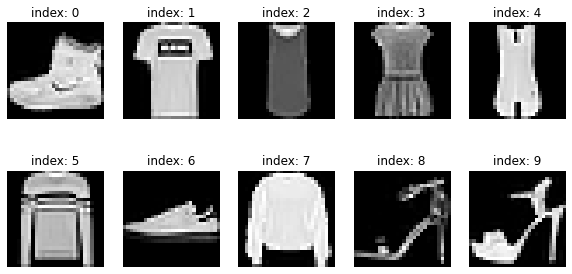

In [7]:
plt.figure(figsize=(10, 5)) # 프레임 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1) # 여러 이미지 띄우기
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

## 2-4. 미니배치 학습을 위한 처리

### 미니배치 학습
- 너무 많은 양을 한번에 학습하면 메모리 활용도 비효율적이고 한번 학습에도 너무 오래 소요

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

### `tf.data.Dataset.from_tensor_slices()`
- 리스트, 넘파이, 텐서 자료형에서 데이터셋 생성
- `.shuffle(BUFFER_SIZE)` : 자료 섞기
    - (**데이터 골고루 섞이게 하려면 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋음**)
- `.batch(BATCH_SIZE)` : 배치 사이즈에 따라 나누기

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# step3) GAN 모델 설계

## 3-1. 생성자 모델 설계
- `tf.keras.Sequntial()` 이용해 모델 레이어 쌓기

### `Conv2DTranspose`
- 일반적인 `Conv2D`와 반대로 이미지 사이즈를 넓혀주는 층
- 3번의 `Conv2DTranspose`를 이용해 우리가 준비했던 데이터셋과 동일한 shape으로 이미지 사이즈 키우기

### `BatchNormalization`
- 신경망의 가중치가 폭발하지 않도록 가중치 값 정규화

### 활성화 함수들
- 중간층들의 활성화 함수는 모두 `LeakyReLU`를 사용하였습니다. 
- 마지막 층에는 활성화 함수로 `tanh`를 사용하는데,
    - 우리가 -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함

- 모델 입력값 : (BATCH_SIZE, 100) 형상의 노이즈 벡터
- 1차원의 값으로 들어감
- Conv 연산전 1차원 벡터를 3차원으로 reshape한다

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

- 학습 전 모델 확인을 위한 노이즈 벡터 입력해보기
- `tf.random.normal` : 가우시안 분포에서 뽑아낸 랜덤 값들로 이루어지는 노이즈 벡터 생성 가능

In [12]:
noise = tf.random.normal([1, 100])

- tf2.0 이후 버전에서는 레이어 및 모델에도 `call()` 메소드가 구현되어 있어서 만들어진 모델에 입력값으로 노이즈를 넣고 모델을 불러도 간단한 결과 이미지 획득 가능
- Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있습니다.

In [13]:
generated_image = generator(noise, training=False) # 학습 중이 아님을 설정해야 BatchNormalization이 제대로 행동한다
generated_image.shape

TensorShape([1, 28, 28, 1])

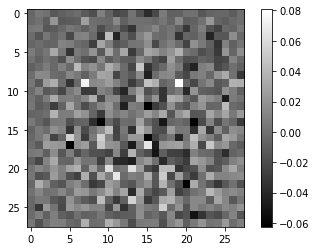

In [14]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## 3-2 판별자 모델 설계
- 가짜 이미지와 진짜 이미지 입력받으면 각 이미지별로 진짜라고 판단하는 정도 값을 출력
- 입력 : (28,28,1) 이미지
- 출력: 진짜라고 판단한 정도 수치

이미지를 키워나갔던 생성자와 반대로,
판별자는 `Conv2D` 층으로 이미지의 크기를 점점 줄여나갑니다.
첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는
다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 됩니다.

마지막에는 `Flatten` 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환합니다.
이는 생성자의 `Reshape` 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 `Dense Layer`를 거쳐 단 하나의 값을 출력하게 됩니다.

In [33]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [27]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [34]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.7294397]], dtype=float32)>

# 이후 13-11 재복습 필요

## 3-3. 손실함수 설계

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

### generator_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator_accuracy

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 3-4. 최적화 함수 선택 `tf.keras.optimizers.Adam()`
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 3-5. 학습 정도 확인을 위한 샘플

- 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

샘플은 한 번에 16장을 생성하도록 하겠습니다.
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# step4) 모델 훈련과정 설계
 한 단계를 학습하는 train_step, 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 학습 과정을 시각화하는 draw_train_history(), 그리고 모델까지 저장하기 위한 checkpoint

## 4-1. 미니배치 마다 실행할 함수
### `텐서플로우 데코레이터`
@tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다.

### `def train_step(images)`
(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
(7) accuracy 계산 : fake_output, real_output으로 discriminator가
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

## 4-2. 학습 현황 확인하는 샘플 생성 함수
고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

- model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # 시각화한 이미지 파일에 저장
    plt.savefig('{}/aiffel/enode13/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

## 4-3. 모델 평가지표로 학습 과정 확인 함수
 GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다. train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/enode13/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

## 4-5. 체크포인트
tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적입니다.
checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장합니다. 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장하는 것이죠. 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/enode13/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# step5) 모델 학습

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

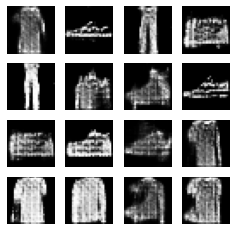

Time for training : 1625 sec


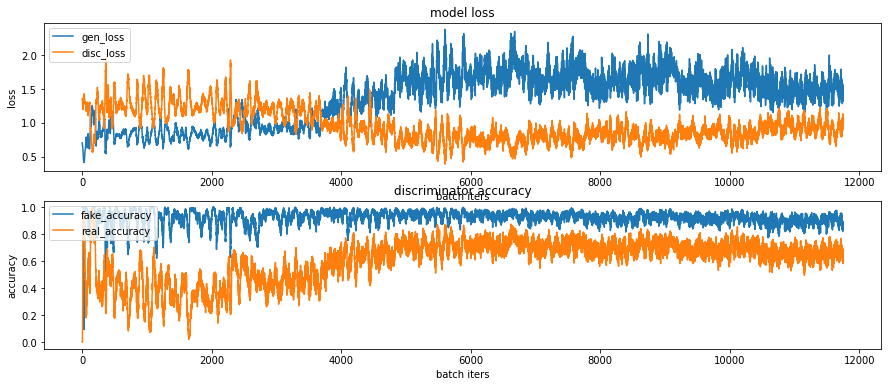

CPU times: user 8min 30s, sys: 56.1 s, total: 9min 26s
Wall time: 27min 6s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻

보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야 합니다. 결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보세요!

In [32]:
anim_file = os.getenv('HOME')+'/aiffel/enode13/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/enode13/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/enode13/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1344451 Aug 28 19:27 /aiffel/aiffel/enode13/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![result.gif](dcgan_newimage/fashion/fashion_mnist_dcgan.gif)